# Import & Config


In [ ]:
# Imports, config, loading raw data

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    classification_report,
)

# Config
DATA_DIR = "/content/"
WINDOW_SAMPLES = 50     # ~5 s at 10 Hz
RANDOM_STATE = 42

RAW_FILES = [
    "indoor_no_sun_afternoon_130PM.csv",
    "indoor_no_sun_evening_4PM.csv",
    "indoor_shade_evening_130PM.csv",
    "indoor_shade_evening_4PM.csv",
    "outdoor_direct_afternoon_130PM.csv",
    "outdoor_direct_evening_4PM.csv",
    "outdoor_shade_afternoon_130PM.csv",
    "outdoor_shade_afternoon_4PM.csv",
]

# Load and concatenate raw CSVs
dfs = []
for fname in RAW_FILES:
    path = os.path.join(DATA_DIR, fname)
    if not os.path.exists(path):
        print("Missing file:", fname)
        continue
    df = pd.read_csv(path)
    df["__source_file"] = fname
    dfs.append(df)

raw = pd.concat(dfs, ignore_index=True)
print("Raw shape:", raw.shape)

# Compute raw UV proxy (UVA + UVB)
raw["UV_proxy"] = raw["UVA"].fillna(0) + raw["UVB"].fillna(0)


Raw shape: (5257, 8)


# Data Visualization

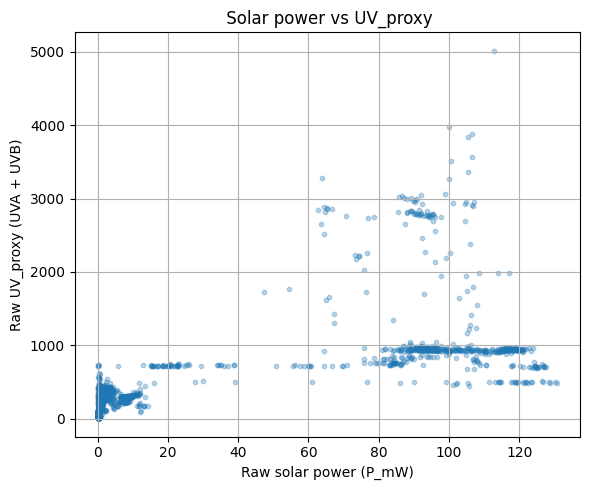

In [ ]:
# Cell 2: Raw data visualizations

plt.figure(figsize=(6, 5))
plt.scatter(raw["P_mW"], raw["UV_proxy"], alpha=0.3, s=10)
plt.xlabel("Raw solar power (P_mW)")
plt.ylabel("Raw UV_proxy (UVA + UVB)")
plt.title(" Solar power vs UV_proxy")
plt.grid(True)
plt.tight_layout()
plt.show()




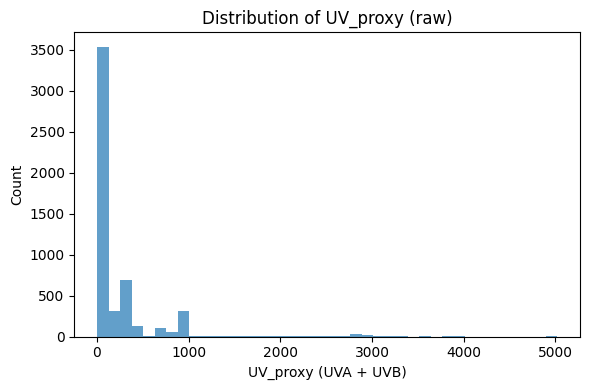

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(raw["UV_proxy"], bins=40, alpha=0.7)
plt.xlabel("UV_proxy (UVA + UVB)")
plt.ylabel("Count")
plt.title("Distribution of UV_proxy (raw)")
plt.tight_layout()
plt.show()

# Data cleaning & Feature Engineering

In [ ]:
# Cleaning, trimming, smoothing, feature engineering

def trim_edges(df, head=20, tail=10):
    if len(df) > (head + tail):
        return df.iloc[head:-tail].reset_index(drop=True)
    return df.reset_index(drop=True)

data = (
    raw
    .groupby("__source_file", group_keys=False)
    .apply(trim_edges, head=20, tail=10)
    .reset_index(drop=True)
)

def apply_moving_average(df, window=5):
    df = df.copy()
    for col in ["V_load_V", "I_mA", "P_mW"]:
        df[col] = df[col].rolling(window, min_periods=1).mean()
    return df

data = (
    data
    .groupby("__source_file", group_keys=False)
    .apply(apply_moving_average, window=5)
    .reset_index(drop=True)
)

print("After trim + smooth:", data.shape)

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna(subset=["time_s", "V_load_V", "I_mA", "P_mW", "UVA", "UVB"])

for col in ["V_load_V", "I_mA", "P_mW", "UVA", "UVB", "UVC"]:
    lo, hi = data[col].quantile([0.001, 0.999])
    data[col] = data[col].clip(lo, hi)

data = data.sort_values(by=["__source_file", "time_s"]).reset_index(drop=True)

data["UV_proxy"] = data["UVA"].fillna(0) + data["UVB"].fillna(0)

def add_rolling_features(df, window=WINDOW_SAMPLES):
    df = df.copy()
    for base in ["V_load_V", "I_mA", "P_mW"]:
        df[f"{base}_roll_mean"] = df[base].rolling(window, min_periods=1).mean()
        df[f"{base}_roll_std"] = df[base].rolling(window, min_periods=1).std().fillna(0)
        df[f"{base}_delta"] = df[base].diff().fillna(0)
    p = df["P_mW"]
    denom = (p.max() - p.min())
    if denom == 0:
        df["irradiance_idx"] = 0.0
    else:
        df["irradiance_idx"] = (p - p.min()) / denom
    return df

data = data.groupby("__source_file", group_keys=False).apply(
    add_rolling_features,
    window=WINDOW_SAMPLES,
)

print("After feature engineering:", data.shape)


After trim + smooth: (5017, 9)
After feature engineering: (5017, 19)


/tmp/ipython-input-2843705981.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(trim_edges, head=20, tail=10)
/tmp/ipython-input-2843705981.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(apply_moving_average, window=5)
/tmp/ipython-input-2843705981.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version o

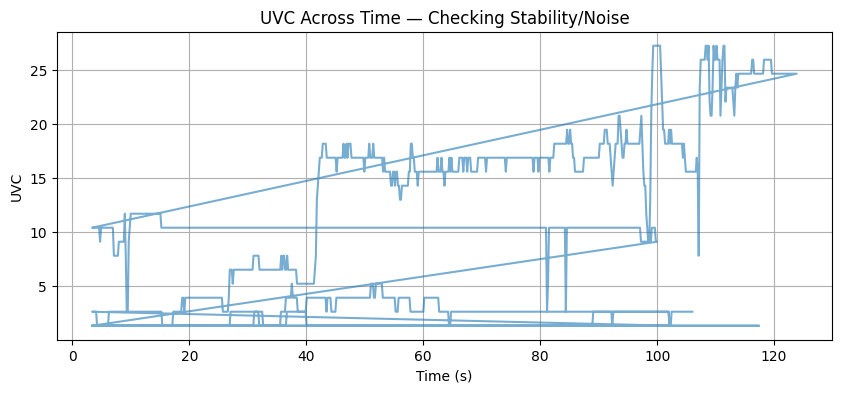

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(data["time_s"], data["UVC"], alpha=0.6)
plt.title("UVC Across Time — Checking Stability/Noise")
plt.xlabel("Time (s)")
plt.ylabel("UVC")
plt.grid(True)
plt.show()

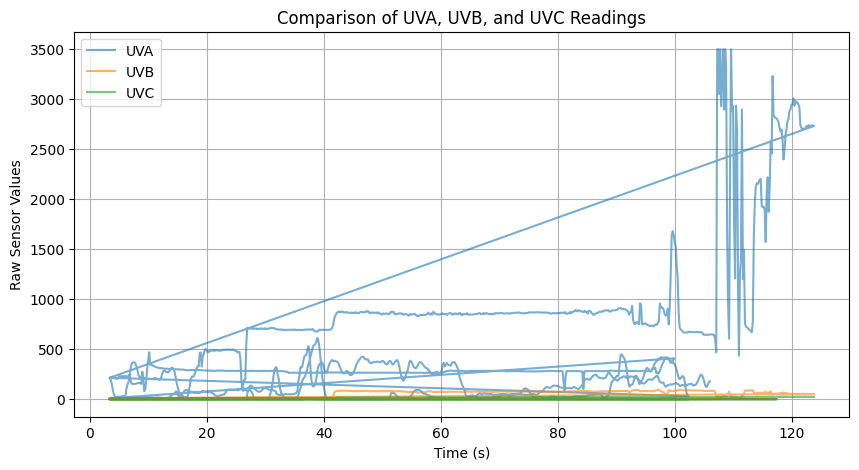

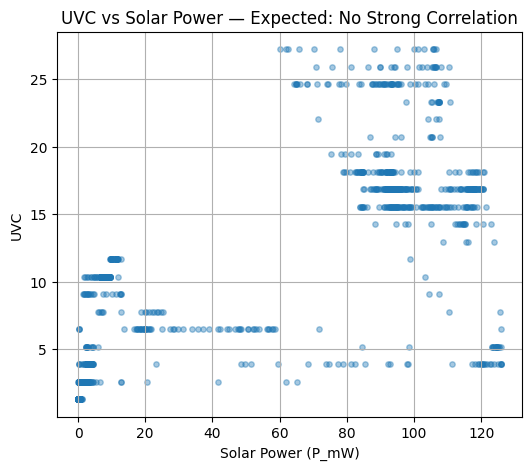

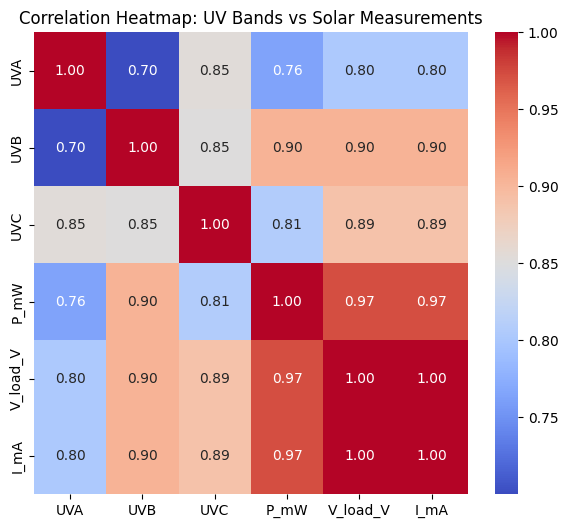

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data["time_s"], data["UVA"], label="UVA", alpha=0.6)
plt.plot(data["time_s"], data["UVB"], label="UVB", alpha=0.6)
plt.plot(data["time_s"], data["UVC"], label="UVC", alpha=0.6)
plt.title("Comparison of UVA, UVB, and UVC Readings")
plt.xlabel("Time (s)")
plt.ylabel("Raw Sensor Values")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 3. UVC vs Solar Power (P_mW)
# -------------------------------
plt.figure(figsize=(6,5))
plt.scatter(data["P_mW"], data["UVC"], alpha=0.4, s=15)
plt.title("UVC vs Solar Power — Expected: No Strong Correlation")
plt.xlabel("Solar Power (P_mW)")
plt.ylabel("UVC")
plt.grid(True)
plt.show()

# -------------------------------
# 4. Correlation Heatmap
# -------------------------------
corr = data[["UVA","UVB","UVC","P_mW","V_load_V","I_mA"]].corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: UV Bands vs Solar Measurements")
plt.show()

# Visualize engineered features vs UV_proxy

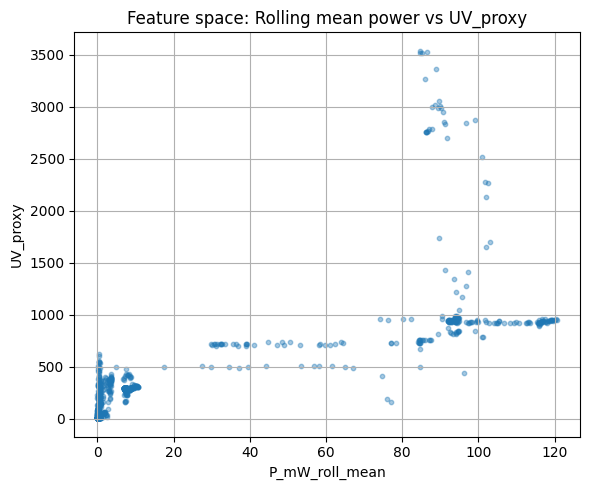

In [ ]:


sample = data.sample(n=min(2000, len(data)), random_state=0)

plt.figure(figsize=(6, 5))
plt.scatter(sample["P_mW_roll_mean"], sample["UV_proxy"], alpha=0.4, s=10)
plt.xlabel("P_mW_roll_mean")
plt.ylabel("UV_proxy")
plt.title("Feature space: Rolling mean power vs UV_proxy")
plt.grid(True)
plt.tight_layout()
plt.show()


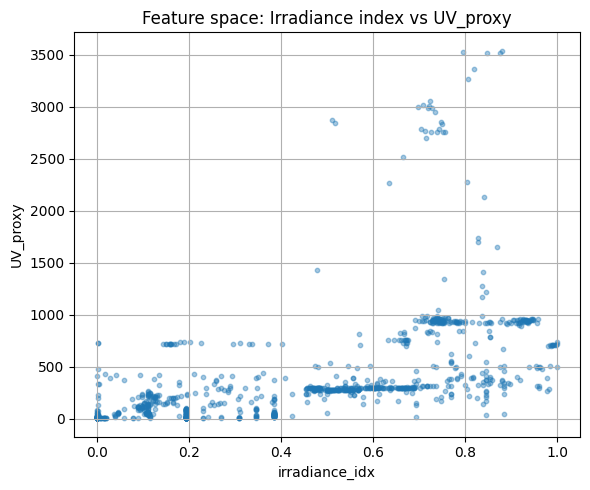

In [ ]:
plt.figure(figsize=(6, 5))
plt.scatter(sample["irradiance_idx"], sample["UV_proxy"], alpha=0.4, s=10)
plt.xlabel("irradiance_idx")
plt.ylabel("UV_proxy")
plt.title("Feature space: Irradiance index vs UV_proxy")
plt.grid(True)
plt.tight_layout()
plt.show()


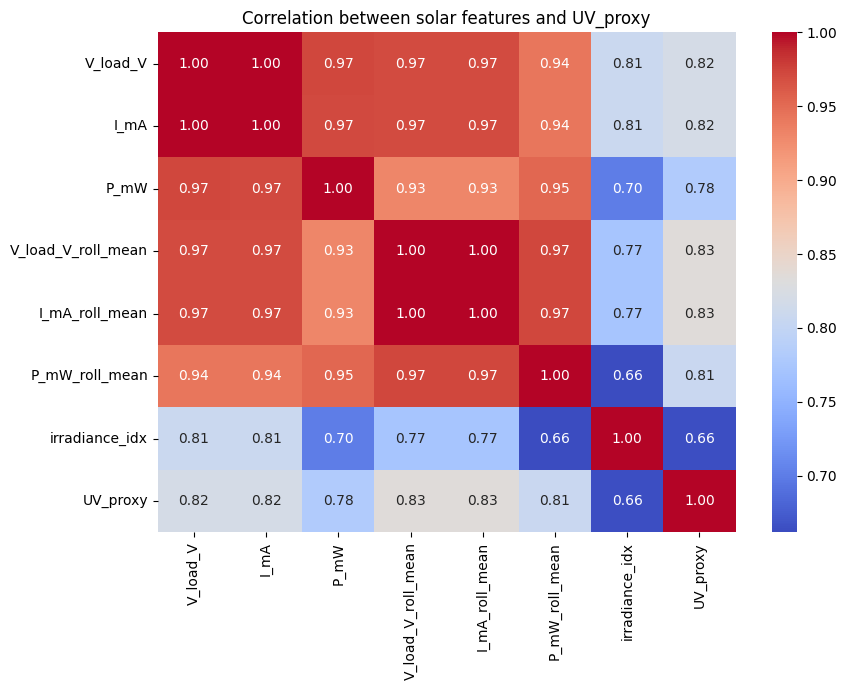

In [ ]:
corr_cols = [
    "V_load_V", "I_mA", "P_mW",
    "V_load_V_roll_mean", "I_mA_roll_mean", "P_mW_roll_mean",
    "irradiance_idx", "UV_proxy",
]

plt.figure(figsize=(9, 7))
sns.heatmap(data[corr_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation between solar features and UV_proxy")
plt.tight_layout()
plt.show()

# Labeling

Binary label counts:
UV_binary
Normal    3306
High      1711
Name: count, dtype: int64


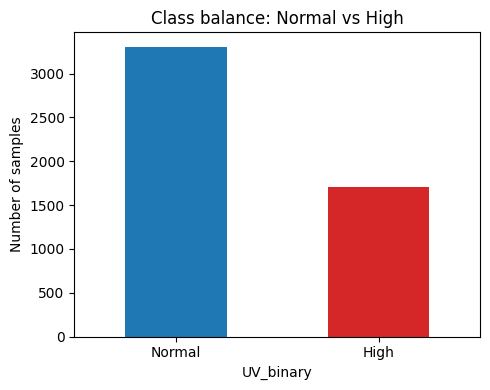

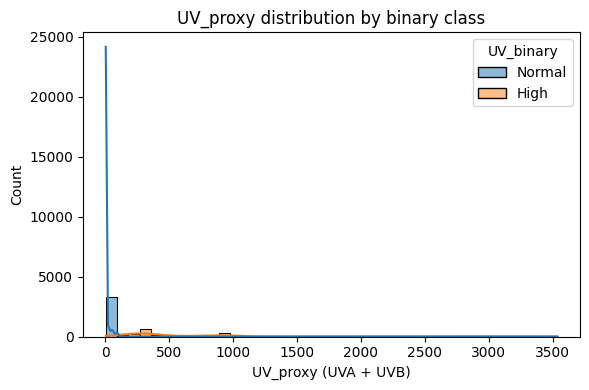

In [ ]:
# Binary labeling (High vs Normal)

q2 = data["UV_proxy"].quantile(0.66)

def label_binary(u):
    if u >= q2:
        return "High"
    else:
        return "Normal"

data["UV_binary"] = data["UV_proxy"].apply(label_binary)

print("Binary label counts:")
print(data["UV_binary"].value_counts())

plt.figure(figsize=(5, 4))
data["UV_binary"].value_counts().plot(kind="bar", color=["tab:blue", "tab:red"])
plt.title("Class balance: Normal vs High")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
print("\n\n")
plt.figure(figsize=(6, 4))
sns.histplot(data, x="UV_proxy", hue="UV_binary", bins=40, kde=True, stat="count")
plt.xlabel("UV_proxy (UVA + UVB)")
plt.title("UV_proxy distribution by binary class")
plt.tight_layout()
plt.show()


# Train/val/test split

In [ ]:
#  Features and train/val/test split

feature_cols = [
    "V_load_V",
    "I_mA",
    "P_mW",
    "V_load_V_roll_mean",
    "I_mA_roll_mean",
    "P_mW_roll_mean",
    "V_load_V_roll_std",
    "I_mA_roll_std",
    "P_mW_roll_std",
    "V_load_V_delta",
    "I_mA_delta",
    "P_mW_delta",
    "irradiance_idx",
]

X = data[feature_cols].values
y = data["UV_binary"].values

unique = np.unique(y)
strat = y if len(unique) > 1 else None

X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=strat,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=RANDOM_STATE,
    stratify=y_temp,
)

print("Train size:", X_train.shape[0])
print("Val size:  ", X_val.shape[0])
print("Test size: ", X_test.shape[0])


Train size: 3513
Val size:   751
Test size:  753


# Baseline Model

[Baseline]
Accuracy: 0.935
F1-macro: 0.927
F1-High: 0.902
[[478  18]
 [ 31 226]]
              precision    recall  f1-score   support

        High      0.926     0.879     0.902       257
      Normal      0.939     0.964     0.951       496

    accuracy                          0.935       753
   macro avg      0.933     0.922     0.927       753
weighted avg      0.935     0.935     0.935       753



<Figure size 400x400 with 0 Axes>

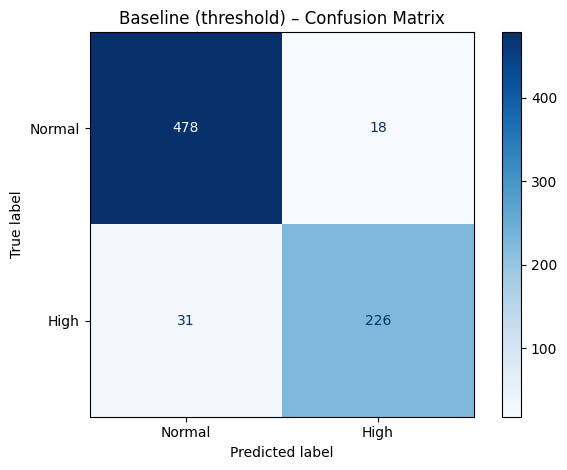

In [ ]:
# Baseline binary classifier
p_feat = data["P_mW"].rolling(WINDOW_SAMPLES, min_periods=1).mean()
p_thr = p_feat.quantile(0.66)

idx_pm = feature_cols.index("P_mW_roll_mean")

def baseline_predict_binary(Xmat):
    preds = []
    for row in Xmat:
        pm = row[idx_pm]
        if pm >= p_thr:
            preds.append("High")
        else:
            preds.append("Normal")
    return np.array(preds)

def f1_for_high(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=["Normal", "High"], zero_division=0
    )
    return f1[1]

y_pred_base = baseline_predict_binary(X_test)
cm_base = confusion_matrix(y_test, y_pred_base, labels=["Normal", "High"])
acc_base = accuracy_score(y_test, y_pred_base)
f1_base_macro = f1_score(y_test, y_pred_base, average="macro")
f1_base_high = f1_for_high(y_test, y_pred_base)

print("[Baseline]")
print("Accuracy:", round(acc_base, 3))
print("F1-macro:", round(f1_base_macro, 3))
print("F1-High:", round(f1_base_high, 3))
print(confusion_matrix(y_test, y_pred_base, labels=["Normal", "High"]))
print(classification_report(y_test, y_pred_base, digits=3))

disp = ConfusionMatrixDisplay(cm_base, display_labels=["Normal", "High"])
plt.figure(figsize=(4, 4))
disp.plot(values_format="d", cmap="Blues")
plt.title("Baseline (threshold) – Confusion Matrix")
plt.tight_layout()
plt.show()


# Model Training

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

models = {}

# Logistic Regression
logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])
logreg_params = {"clf__C": [0.1, 1.0, 10.0]}

logreg_grid = GridSearchCV(
    logreg,
    logreg_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
)
logreg_grid.fit(X_train, y_train)
models["LogisticRegression"] = logreg_grid.best_estimator_

# SVM
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf"))
])
svm_params = {
    "clf__C": [0.5, 1, 2],
    "clf__gamma": ["scale", 0.1, 0.01],
}

svm_grid = GridSearchCV(
    svm,
    svm_params,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
)
svm_grid.fit(X_train, y_train)
models["SVM_RBF"] = svm_grid.best_estimator_

print("Trained models:", list(models.keys()))

Trained models: ['LogisticRegression', 'SVM_RBF']


# Evaluation & Confusion Matrix


[Baseline]
Accuracy: 0.935
F1-macro: 0.927
F1-High: 0.902
[[478  18]
 [ 31 226]]
              precision    recall  f1-score   support

        High      0.926     0.879     0.902       257
      Normal      0.939     0.964     0.951       496

    accuracy                          0.935       753
   macro avg      0.933     0.922     0.927       753
weighted avg      0.935     0.935     0.935       753



<Figure size 400x400 with 0 Axes>

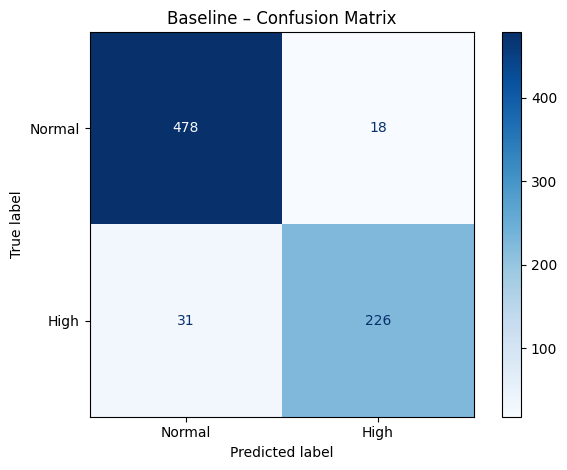


[LogisticRegression]
Accuracy: 0.971
F1-macro: 0.967
F1-High: 0.956
[[492   4]
 [ 18 239]]
              precision    recall  f1-score   support

        High      0.984     0.930     0.956       257
      Normal      0.965     0.992     0.978       496

    accuracy                          0.971       753
   macro avg      0.974     0.961     0.967       753
weighted avg      0.971     0.971     0.971       753



<Figure size 400x400 with 0 Axes>

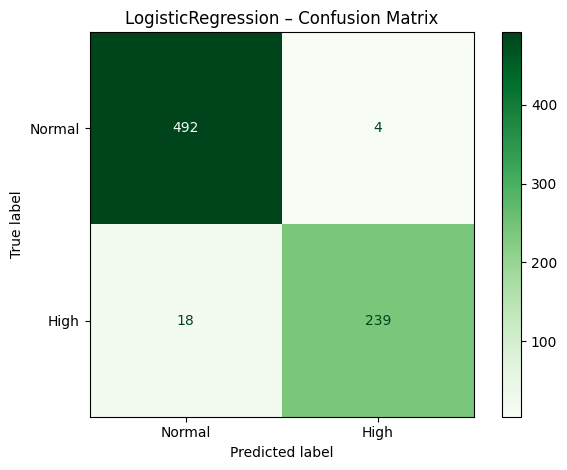


[SVM_RBF]
Accuracy: 0.961
F1-macro: 0.956
F1-High: 0.941
[[494   2]
 [ 27 230]]
              precision    recall  f1-score   support

        High      0.991     0.895     0.941       257
      Normal      0.948     0.996     0.971       496

    accuracy                          0.961       753
   macro avg      0.970     0.945     0.956       753
weighted avg      0.963     0.961     0.961       753



<Figure size 400x400 with 0 Axes>

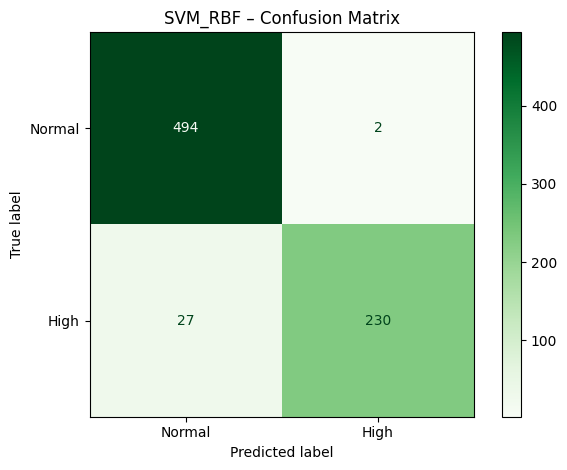

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import numpy as np

results = {}

# Baseline: threshold on rolling mean power
y_pred_base = baseline_predict_binary(X_test)
cm_base = confusion_matrix(y_test, y_pred_base, labels=["Normal", "High"])
acc_base = accuracy_score(y_test, y_pred_base)
f1_base_macro = f1_score(y_test, y_pred_base, average="macro")
f1_base_high = f1_for_high(y_test, y_pred_base)

results["Baseline"] = {
    "accuracy": acc_base,
    "f1_macro": f1_base_macro,
    "f1_high": f1_base_high,
    "cm": cm_base,
}

print("\n[Baseline]")
print("Accuracy:", round(acc_base, 3))
print("F1-macro:", round(f1_base_macro, 3))
print("F1-High:", round(f1_base_high, 3))
print(cm_base)
print(classification_report(y_test, y_pred_base, digits=3))

disp = ConfusionMatrixDisplay(cm_base, display_labels=["Normal", "High"])
plt.figure(figsize=(4, 4))
disp.plot(values_format="d", cmap="Blues")
plt.title("Baseline – Confusion Matrix")
plt.tight_layout()
plt.show()

# ML models
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=["Normal", "High"])
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    f1h = f1_for_high(y_test, y_pred)

    results[name] = {
        "accuracy": acc,
        "f1_macro": f1m,
        "f1_high": f1h,
        "cm": cm,
    }

    print(f"\n[{name}]")
    print("Accuracy:", round(acc, 3))
    print("F1-macro:", round(f1m, 3))
    print("F1-High:", round(f1h, 3))
    print(cm)
    print(classification_report(y_test, y_pred, digits=3))

    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "High"])
    plt.figure(figsize=(4, 4))
    disp.plot(values_format="d", cmap="Greens")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()

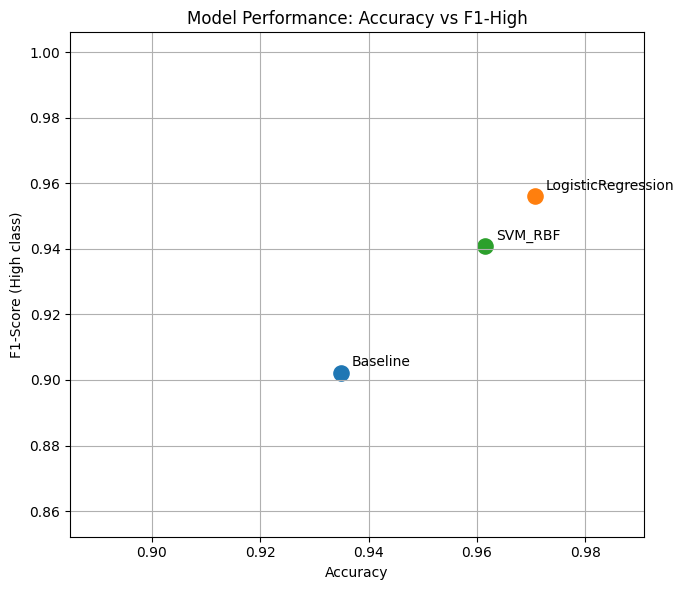

In [ ]:
model_names = list(results.keys())
accs = [results[m]["accuracy"] for m in model_names]
f1_highs = [results[m]["f1_high"] for m in model_names]

plt.figure(figsize=(7, 6))

for name, acc, f1h in zip(model_names, accs, f1_highs):
    plt.scatter(acc, f1h, s=120)
    plt.text(acc + 0.002, f1h + 0.002, name)

plt.xlabel("Accuracy")
plt.ylabel("F1-Score (High class)")
plt.title("Model Performance: Accuracy vs F1-High")
plt.grid(True)
plt.xlim(max(0.8, min(accs) - 0.05), min(1.02, max(accs) + 0.02))
plt.ylim(max(0.0, min(f1_highs) - 0.05), min(1.05, max(f1_highs) + 0.05))
plt.tight_layout()
plt.show()

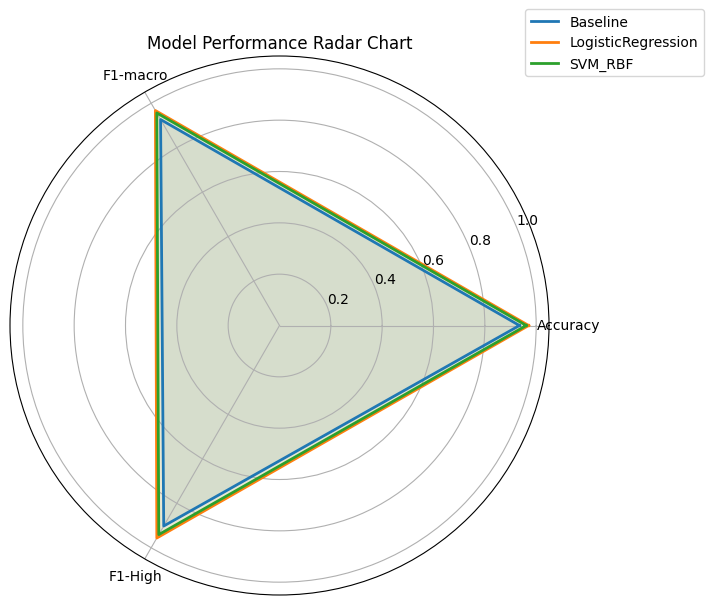

In [ ]:
metrics = ["accuracy", "f1_macro", "f1_high"]
models_for_radar = list(results.keys())  # Baseline, LogisticRegression, SVM

values = []
for m in models_for_radar:
    vals = [results[m][k] for k in metrics]
    values.append(vals)

num_metrics = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, polar=True)

for model_name, vals in zip(models_for_radar, values):
    stats = vals + vals[:1]
    ax.plot(angles, stats, linewidth=2, label=model_name)
    ax.fill(angles, stats, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(["Accuracy", "F1-macro", "F1-High"])
ax.set_ylim(0.0, 1.05)
ax.set_title("Model Performance Radar Chart")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()